# Purpose and plan

In this project, I will attempt to estimate the height of an individual based on their weight, gender, and BMI. I will implement Keras for the machine learning part of this assignment, and use Pandas and Matplotlib for data explotation. I know that the BMI of a person is calculated with height and weight, so I'm hoping that this model will ferrit out the relationship, (BMI = Kg/M^2,) and be able to accuractly predict height.

# Setup

First, I'll import all needed libraries, and set things up so that this project should run smoothly on as many machines as possible. We also want to plot figures inline, so I'll use the built in Jupyter-Notebook magic for that.

In [1]:
# make sure we can support Python 2
from __future__ import division, print_function, unicode_literals

# import our necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import keras
import os

# Plot figures in the notebook with Jupyter-Notebook magic
%matplotlib inline

# give everything a random seed so that we get repeatable results.
seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

Using TensorFlow backend.


Time to import data from our CSV file! The file is named "HeightWeightData.csv," nd is stored in the same directory as this notebook. 

In [2]:
# create paths for the loading of data, saving of models, and the saving of images.
DATA_PATH = "./HeightWeightData.csv"

if not os.path.exists("Figures"):
    os.makedirs("Figures")

if not os.path.exists("Models"):
    os.makedirs("Models")    
    
FIGURE_PATH = "./Figures/"

# Exploring and visualizing the data:

Based on the online description of the dataset, the data should be structured as follows:

    Gender : Male / Female

    Height : Number (cm)

    Weight : Number (Kg)

    Index :

        0 - Extremely Weak

        1 - Weak

        2 - Normal

        3 - Overweight

        4 - Obesity

        5 - Extreme Obesity
        
Now, just to make sure that there are no surprises, let's check out the data after importing it into a pandas DataFrame: 

In [3]:
data = pd.read_csv(DATA_PATH)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
Gender    500 non-null object
Height    500 non-null int64
Weight    500 non-null int64
Index     500 non-null int64
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


,Height,Weight,Index
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


There is a single categorical data column to deal with. Let's explore what it contains, and in what amounts:

In [4]:
print(data["Gender"].value_counts())

Female    255
Male      245
Name: Gender, dtype: int64


Now we'll get some more information on how non-categorical features are spread out with the handy pandas hist() method.

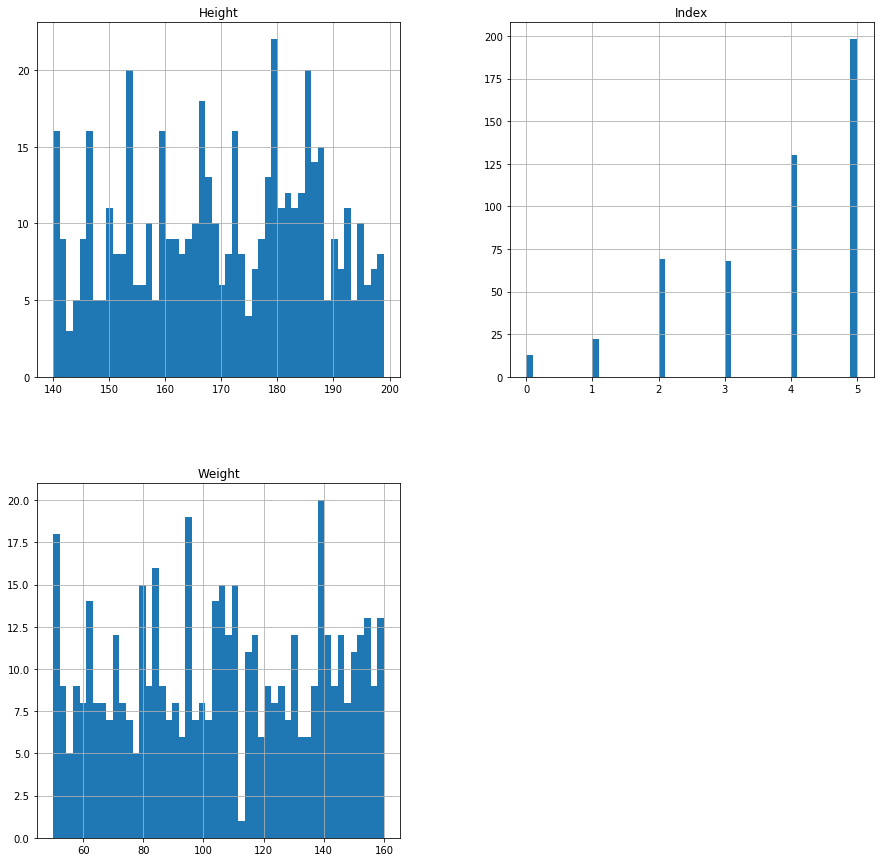

In [5]:
data.hist(bins=50, figsize = [15, 15])
plt.show()

Because the hist() mehtod ignores categorical data, I'll just grab the value_counts of each variable in the "Gender" column, and plot those so that we have all variables visualized.

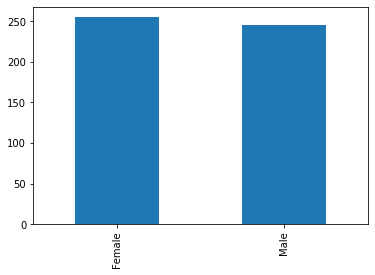

In [6]:
data["Gender"].value_counts().plot(kind="bar")#can't hist() on categorical.
plt.show()

What I've noticed so far is:

1) The data has buit in ratios. There are more females than males in the data, and there are a lot more people in the BMI "5" range than the other ranges. This will require some stratified splitting later if we want to avoid random sampling bias in the training/test sets.

2) There appears to be an obvious relationship between weight and height. I think the reason that the histogram for height and the histogram for weight are jumpy is the fact that there are only 500 instances in this set. I'm definately seeing parallels between the amount of people in a certain range of height, and the amount of people in a certain range of weight. If there were more instances, I think we'd see a much smoother top to the graph. (That smoothness doesn't have to be a straight line, of course.)

I'll continue with a scatter matrix and correlation matrix:

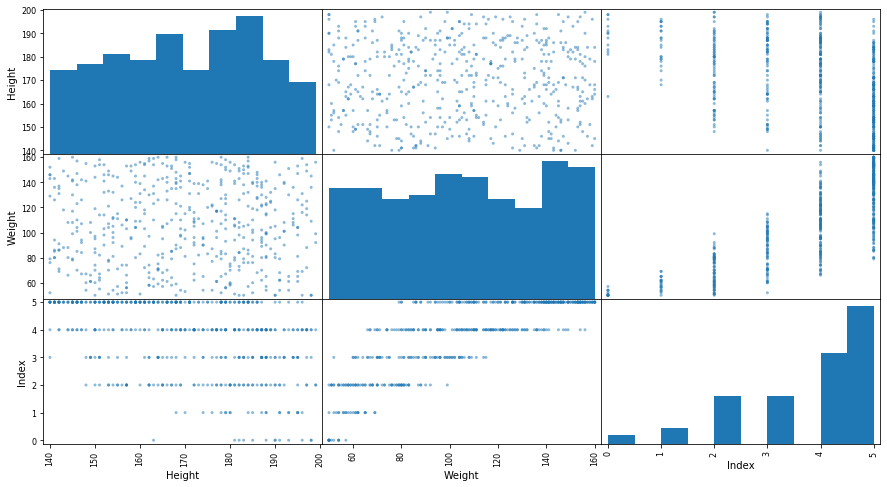


          Height    Weight     Index
Height  1.000000  0.000446 -0.422223
Weight  0.000446  1.000000  0.804569
Index  -0.422223  0.804569  1.000000


In [7]:
from pandas.plotting import scatter_matrix

scatter_matrix(data, figsize=[15,8])
plt.show()

print("")
corr_matrix = data.corr()
print(corr_matrix)

Well after the scatter matrix and correlation matrix, I can tell that my previous assumptions about height and weight were incorrect. The relationship between height and weight is pretty much nothing. However, because BMI links the two with an equation, I am hoping that I can get my model to discover that relationship, and reverse-engineer it, so that it can accurately predict height. I'm hoping that I don't have to add another feature like (Weight/Height) to give the model any hints.

# Process the data for machine learning:
As I mentioned previousely, we will need to be carefule when splitting up the data. I need the test/train matrices of features, (Index, Gender, and Weight,) and labels, (Height.) I also need to come up with a way to deal with the categorical data. This means that the first order of business is to throw the "Gender" column into a one-hot encoder in order to avoid the problems of false correlation that an ordinal encoder would cause.

In [8]:
temp_genders = pd.get_dummies(data["Gender"], prefix="Gender")
data = data.drop(["Gender"], axis=1)
data["Gender_Male"] = temp_genders["Gender_Male"]
data["Gender_Female"] = temp_genders["Gender_Female"]

I'll be doing stratified splitting of the data based around the "Index" feature, because it has the most variance, and I think it will have more effect than something like "Gender" in which the spread is fairly even. The docs for scikit-learn say that the y parameter in the StratifiedShuffleSplit method is supposed to be the target variable in the data, so I guess this is a bit of an experiment.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
for train_index, test_index in split.split(data, data["Index"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]
    
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.11, random_state=42) 
for train_index, valid_index in split2.split(train_set, train_set["Index"]):
    train_set = data.loc[train_index]
    valid_set = data.loc[valid_index]

Now that I've split the data up, I'd like to make sure that everything worked out. I'll make a get_dataframe_info() method to check out the shape and 'head' of a data subset, and I'll create some histograms to compare the 'Index' columns' spread between the different data sets.

In [10]:
def get_dataframe_info(dframe, name):
    print("---------------------------------")
    print(name)
    print("")
    print("shape: " + str(np.shape(dframe)))
    print("")
    print(dframe.head())
    print("")

In [11]:
def get_array_info(array, name):
    print("------------------------")
    print(name + ":")
    print("")
    print("shape : " + str(np.shape(array)))
    print("")
    print("first 5 rows:")
    print(array[:5])
    print("")

In [12]:
#make sure everything went smoothly with the splitting:    
get_dataframe_info(train_set, "train_set")
get_dataframe_info(test_set, "test_set")
get_dataframe_info(valid_set, "valid_set")

---------------------------------
train_set

shape: (400, 5)

     Height  Weight  Index  Gender_Male  Gender_Female
147     140     146      5            0              1
377     178     142      5            1              0
105     195     126      4            1              0
7       154     111      5            1              0
179     188     100      3            1              0

---------------------------------
test_set

shape: (50, 5)

     Height  Weight  Index  Gender_Male  Gender_Female
201     179      93      3            1              0
383     151     154      5            1              0
382     177     117      4            1              0
159     181     105      4            1              0
390     167      58      2            0              1

---------------------------------
valid_set

shape: (50, 5)

     Height  Weight  Index  Gender_Male  Gender_Female
449     159     145      5            1              0
155     179     103      4            0      

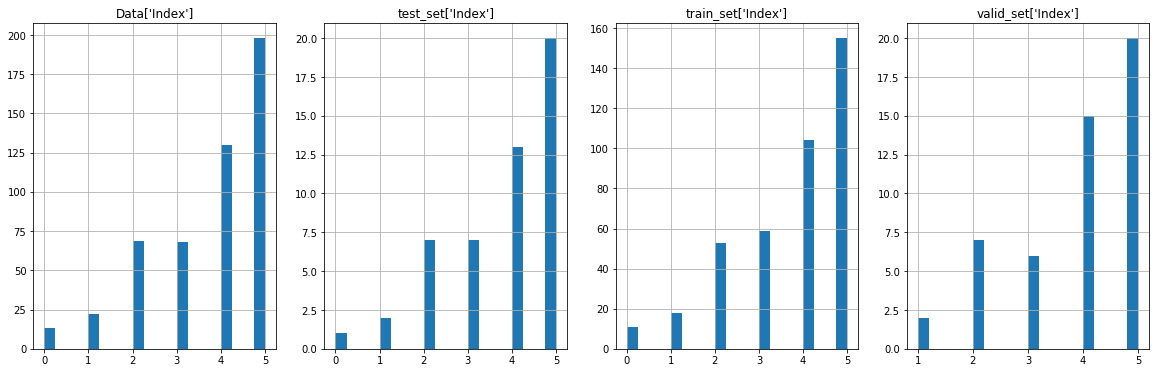

In [13]:
fig = plt.figure(figsize=(20, 6))

dataIndex = fig.add_subplot(1, 4, 1)
data["Index"].hist(bins=20)
dataIndex.title.set_text("Data['Index']")

testIndex = fig.add_subplot(1, 4, 2)
test_set["Index"].hist(bins=20)
testIndex.title.set_text("test_set['Index']")


trainIndex = fig.add_subplot(1, 4, 3)
train_set["Index"].hist(bins=20)
trainIndex.title.set_text("train_set['Index']")

validIndex = fig.add_subplot(1, 4, 4)
valid_set["Index"].hist(bins=20)
validIndex.title.set_text("valid_set['Index']")

plt.show()

We now have a test_set, valid_set, and train_set. I'm content with how those "Index" feature distributions turned out, so I'll move on to creating the label/feature subsets.

In [14]:
train_features = train_set[["Weight", "Gender_Male", "Gender_Female", "Index"]]
train_labels = train_set[["Height"]]

test_features = test_set[["Weight", "Gender_Male", "Gender_Female", "Index"]]
test_labels = test_set[["Height"]]

valid_features = valid_set[["Weight", "Gender_Male", "Gender_Female", "Index"]]
valid_labels = valid_set[["Height"]]

After several attempts at using the default features provided with this dataset, I have decided to change the "Index" column in all of the subsets. Becasue "Index" falls into one of five different categories, there is not enough information given to the model, and I am unable to get my loss lower than around 70. I'll turn all "Index" columns into an actual BMI measurement, which is calculated as: BMI = (Weight in Kilograms)/(Height in Meters squared)

In [25]:
def fix_index_column(dframe):
    dframe["Index"] = dframe["Weight"]/(dframe["Height"]/100)**2

fix_index_column(train_set)
fix_index_column(test_set)
fix_index_column(valid_set)

print(train_set.head())
print("")
print(train_set.corr())

     Height  Weight      Index  Gender_Male  Gender_Female
147     140     146  74.489796            0              1
377     178     142  44.817574            1              0
105     195     126  33.136095            1              0
7       154     111  46.803846            1              0
179     188     100  28.293345            1              0

                 Height    Weight     Index  Gender_Male  Gender_Female
Height         1.000000  0.000080 -0.529824    -0.010733       0.010733
Weight         0.000080  1.000000  0.828242     0.000309      -0.000309
Index         -0.529824  0.828242  1.000000     0.018109      -0.018109
Gender_Male   -0.010733  0.000309  0.018109     1.000000      -1.000000
Gender_Female  0.010733 -0.000309 -0.018109    -1.000000       1.000000


In [16]:
#optional: get some info on the sets.
get_dataframe_info(train_features, "train_features")
get_dataframe_info(train_labels, "train_labels")
get_dataframe_info(test_features, "test_features")
get_dataframe_info(test_labels, "test_labels")
get_dataframe_info(valid_features, "valid_features")
get_dataframe_info(valid_labels, "valid_labels")

---------------------------------
train_features

shape: (400, 4)

     Weight  Gender_Male  Gender_Female  Index
147     146            0              1      5
377     142            1              0      5
105     126            1              0      4
7       111            1              0      5
179     100            1              0      3

---------------------------------
train_labels

shape: (400, 1)

     Height
147     140
377     178
105     195
7       154
179     188

---------------------------------
test_features

shape: (50, 4)

     Weight  Gender_Male  Gender_Female  Index
201      93            1              0      3
383     154            1              0      5
382     117            1              0      4
159     105            1              0      4
390      58            0              1      2

---------------------------------
test_labels

shape: (50, 1)

     Height
201     179
383     151
382     177
159     181
390     167

----------------------------

As a final step before creating the neural network, I'll use a MinMaxScalar to rescale the data into a range between 0 and 1. I'm not worried about outliers, because there don't appear to be any. I decided not to scale my labels, because I found some material saying that this is not nescissary. Note: the MinMaxScaler outputs ndarray objects instead of the origional dataframes, so I'll convert all label sets to ndarrays as well.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)
valid_features = scaler.fit_transform(valid_features)

train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()
valid_labels = valid_labels.to_numpy()

#train_labels = scaler.fit_transform(train_labels)
#test_labels = scaler.fit_transform(test_labels)
#valid_labels = scaler.fit_transform(valid_labels)

In [18]:
get_array_info(train_features, "train_features")
get_array_info(train_labels, "train_labels")

------------------------
train_features:

shape : (400, 4)

first 5 rows:
[[0.87272727 0.         1.         1.        ]
 [0.83636364 1.         0.         1.        ]
 [0.69090909 1.         0.         0.8       ]
 [0.55454545 1.         0.         1.        ]
 [0.45454545 1.         0.         0.6       ]]

------------------------
train_labels:

shape : (400, 1)

first 5 rows:
[[140]
 [178]
 [195]
 [154]
 [188]]



# Prepare the machine learning algorithm

Now that the data is ready for machine learning, I will use Keras to create a feedforward neural network with densly connected layers.

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

keras.backend.clear_session()
model = Sequential()

model.add(Dense(10, activation="relu", input_shape=[4,]))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


I'll use Mean Squared Error as the loss for this, and also use it for metrics, because this is a regression problem.

In [31]:
model.compile(
 #optimizer = "adam",
 optimizer = tf.keras.optimizers.Adam(learning_rate=0.2),
 loss = "mean_squared_error",
 metrics = ["mean_squared_error"]
)

Time to train the model! I'll be using a callback that saves only the best model during this.

In [38]:
save_cb = keras.callbacks.ModelCheckpoint("./Models/proj_7_best_model.h5", save_best_only=True)

results = model.fit(
 train_features, train_labels,
 epochs= 2500,
 batch_size = 40,
 validation_data = (valid_features, valid_labels),
 callbacks=[save_cb]
)

Train on 400 samples, validate on 50 samples
Epoch 1/2500
400/400 [==============================] - 0s 30us/step - loss: 93.4660 - mean_squared_error: 93.4660 - val_loss: 107.5496 - val_mean_squared_error: 107.5496
Epoch 2/2500
400/400 [==============================] - 0s 27us/step - loss: 111.7248 - mean_squared_error: 111.7248 - val_loss: 116.3876 - val_mean_squared_error: 116.3876
Epoch 3/2500
400/400 [==============================] - 0s 30us/step - loss: 114.9752 - mean_squared_error: 114.9752 - val_loss: 107.1351 - val_mean_squared_error: 107.1351
Epoch 4/2500
400/400 [==============================] - 0s 25us/step - loss: 123.7227 - mean_squared_error: 123.7227 - val_loss: 154.4238 - val_mean_squared_error: 154.4238
Epoch 5/2500
400/400 [==============================] - 0s 25us/step - loss: 139.0502 - mean_squared_error: 139.0502 - val_loss: 189.3073 - val_mean_squared_error: 189.3073
Epoch 6/2500
400/400 [==============================] - 0s 30us/step - loss: 128.9844 - mean

400/400 [==============================] - 0s 27us/step - loss: 105.1419 - mean_squared_error: 105.1419 - val_loss: 209.2894 - val_mean_squared_error: 209.2894
Epoch 49/2500
400/400 [==============================] - 0s 25us/step - loss: 106.4816 - mean_squared_error: 106.4816 - val_loss: 96.0345 - val_mean_squared_error: 96.0345
Epoch 50/2500
400/400 [==============================] - 0s 27us/step - loss: 109.3132 - mean_squared_error: 109.3132 - val_loss: 176.6156 - val_mean_squared_error: 176.6156
Epoch 51/2500
400/400 [==============================] - 0s 27us/step - loss: 105.4201 - mean_squared_error: 105.4201 - val_loss: 120.5947 - val_mean_squared_error: 120.5947
Epoch 52/2500
400/400 [==============================] - 0s 25us/step - loss: 96.8479 - mean_squared_error: 96.8479 - val_loss: 95.3326 - val_mean_squared_error: 95.3326
Epoch 53/2500
400/400 [==============================] - 0s 25us/step - loss: 93.3766 - mean_squared_error: 93.3766 - val_loss: 110.5872 - val_mean_sq

Epoch 95/2500
400/400 [==============================] - 0s 25us/step - loss: 119.9713 - mean_squared_error: 119.9713 - val_loss: 170.3384 - val_mean_squared_error: 170.3384
Epoch 96/2500
400/400 [==============================] - 0s 27us/step - loss: 128.9533 - mean_squared_error: 128.9533 - val_loss: 100.4875 - val_mean_squared_error: 100.4875
Epoch 97/2500
400/400 [==============================] - 0s 27us/step - loss: 106.2065 - mean_squared_error: 106.2065 - val_loss: 180.3290 - val_mean_squared_error: 180.3290
Epoch 98/2500
400/400 [==============================] - 0s 25us/step - loss: 114.2002 - mean_squared_error: 114.2002 - val_loss: 149.5805 - val_mean_squared_error: 149.5804
Epoch 99/2500
400/400 [==============================] - 0s 25us/step - loss: 114.0308 - mean_squared_error: 114.0308 - val_loss: 98.0961 - val_mean_squared_error: 98.0961
Epoch 100/2500
400/400 [==============================] - 0s 25us/step - loss: 103.9855 - mean_squared_error: 103.9855 - val_loss: 8

Epoch 142/2500
400/400 [==============================] - 0s 27us/step - loss: 103.1182 - mean_squared_error: 103.1182 - val_loss: 87.6832 - val_mean_squared_error: 87.6832
Epoch 143/2500
400/400 [==============================] - 0s 27us/step - loss: 97.4530 - mean_squared_error: 97.4530 - val_loss: 123.4570 - val_mean_squared_error: 123.4570
Epoch 144/2500
400/400 [==============================] - 0s 25us/step - loss: 93.2132 - mean_squared_error: 93.2132 - val_loss: 132.1855 - val_mean_squared_error: 132.1855
Epoch 145/2500
400/400 [==============================] - 0s 25us/step - loss: 95.7093 - mean_squared_error: 95.7093 - val_loss: 127.6103 - val_mean_squared_error: 127.6103
Epoch 146/2500
400/400 [==============================] - 0s 27us/step - loss: 96.7266 - mean_squared_error: 96.7266 - val_loss: 173.9613 - val_mean_squared_error: 173.9613
Epoch 147/2500
400/400 [==============================] - 0s 30us/step - loss: 106.7870 - mean_squared_error: 106.7870 - val_loss: 89.8

400/400 [==============================] - 0s 27us/step - loss: 138.9256 - mean_squared_error: 138.9256 - val_loss: 120.7917 - val_mean_squared_error: 120.7917
Epoch 190/2500
400/400 [==============================] - 0s 25us/step - loss: 144.1254 - mean_squared_error: 144.1254 - val_loss: 152.9682 - val_mean_squared_error: 152.9682
Epoch 191/2500
400/400 [==============================] - 0s 30us/step - loss: 125.8394 - mean_squared_error: 125.8393 - val_loss: 262.8282 - val_mean_squared_error: 262.8282
Epoch 192/2500
400/400 [==============================] - 0s 30us/step - loss: 132.7331 - mean_squared_error: 132.7331 - val_loss: 127.5114 - val_mean_squared_error: 127.5114
Epoch 193/2500
400/400 [==============================] - 0s 30us/step - loss: 101.8445 - mean_squared_error: 101.8445 - val_loss: 134.9643 - val_mean_squared_error: 134.9643
Epoch 194/2500
400/400 [==============================] - 0s 30us/step - loss: 101.0893 - mean_squared_error: 101.0893 - val_loss: 161.3098 

Epoch 236/2500
400/400 [==============================] - 0s 30us/step - loss: 104.3348 - mean_squared_error: 104.3348 - val_loss: 142.7071 - val_mean_squared_error: 142.7071
Epoch 237/2500
400/400 [==============================] - 0s 30us/step - loss: 100.4482 - mean_squared_error: 100.4482 - val_loss: 115.8624 - val_mean_squared_error: 115.8624
Epoch 238/2500
400/400 [==============================] - 0s 32us/step - loss: 104.9220 - mean_squared_error: 104.9220 - val_loss: 110.4227 - val_mean_squared_error: 110.4227
Epoch 239/2500
400/400 [==============================] - 0s 35us/step - loss: 101.5365 - mean_squared_error: 101.5365 - val_loss: 158.8287 - val_mean_squared_error: 158.8287
Epoch 240/2500
400/400 [==============================] - 0s 32us/step - loss: 104.7684 - mean_squared_error: 104.7684 - val_loss: 122.0352 - val_mean_squared_error: 122.0352
Epoch 241/2500
400/400 [==============================] - 0s 30us/step - loss: 112.9461 - mean_squared_error: 112.9461 - val_

400/400 [==============================] - 0s 32us/step - loss: 92.2087 - mean_squared_error: 92.2087 - val_loss: 163.1450 - val_mean_squared_error: 163.1450
Epoch 284/2500
400/400 [==============================] - 0s 30us/step - loss: 99.0576 - mean_squared_error: 99.0576 - val_loss: 96.0180 - val_mean_squared_error: 96.0180
Epoch 285/2500
400/400 [==============================] - 0s 27us/step - loss: 105.7900 - mean_squared_error: 105.7900 - val_loss: 253.3763 - val_mean_squared_error: 253.3763
Epoch 286/2500
400/400 [==============================] - 0s 32us/step - loss: 118.8577 - mean_squared_error: 118.8577 - val_loss: 105.8433 - val_mean_squared_error: 105.8433
Epoch 287/2500
400/400 [==============================] - 0s 27us/step - loss: 106.1761 - mean_squared_error: 106.1761 - val_loss: 130.2892 - val_mean_squared_error: 130.2892
Epoch 288/2500
400/400 [==============================] - 0s 32us/step - loss: 122.8144 - mean_squared_error: 122.8144 - val_loss: 118.2416 - val_

400/400 [==============================] - 0s 27us/step - loss: 102.4138 - mean_squared_error: 102.4138 - val_loss: 124.2125 - val_mean_squared_error: 124.2125
Epoch 331/2500
400/400 [==============================] - 0s 25us/step - loss: 99.5068 - mean_squared_error: 99.5068 - val_loss: 127.5879 - val_mean_squared_error: 127.5879
Epoch 332/2500
400/400 [==============================] - 0s 25us/step - loss: 94.4284 - mean_squared_error: 94.4284 - val_loss: 141.9330 - val_mean_squared_error: 141.9330
Epoch 333/2500
400/400 [==============================] - 0s 27us/step - loss: 101.3301 - mean_squared_error: 101.3301 - val_loss: 131.5702 - val_mean_squared_error: 131.5702
Epoch 334/2500
400/400 [==============================] - 0s 27us/step - loss: 133.0091 - mean_squared_error: 133.0092 - val_loss: 88.9060 - val_mean_squared_error: 88.9060
Epoch 335/2500
400/400 [==============================] - 0s 25us/step - loss: 106.7956 - mean_squared_error: 106.7956 - val_loss: 161.5413 - val_

400/400 [==============================] - 0s 25us/step - loss: 99.7582 - mean_squared_error: 99.7582 - val_loss: 92.7898 - val_mean_squared_error: 92.7898
Epoch 378/2500
400/400 [==============================] - 0s 27us/step - loss: 97.8134 - mean_squared_error: 97.8135 - val_loss: 129.3910 - val_mean_squared_error: 129.3910
Epoch 379/2500
400/400 [==============================] - 0s 25us/step - loss: 94.3260 - mean_squared_error: 94.3260 - val_loss: 115.2724 - val_mean_squared_error: 115.2724
Epoch 380/2500
400/400 [==============================] - 0s 27us/step - loss: 91.2685 - mean_squared_error: 91.2685 - val_loss: 127.7873 - val_mean_squared_error: 127.7873
Epoch 381/2500
400/400 [==============================] - 0s 27us/step - loss: 95.2018 - mean_squared_error: 95.2018 - val_loss: 144.2115 - val_mean_squared_error: 144.2115
Epoch 382/2500
400/400 [==============================] - 0s 27us/step - loss: 100.8300 - mean_squared_error: 100.8300 - val_loss: 176.4976 - val_mean_s

400/400 [==============================] - 0s 25us/step - loss: 103.4758 - mean_squared_error: 103.4759 - val_loss: 106.9923 - val_mean_squared_error: 106.9923
Epoch 425/2500
400/400 [==============================] - 0s 27us/step - loss: 102.8912 - mean_squared_error: 102.8912 - val_loss: 176.8671 - val_mean_squared_error: 176.8671
Epoch 426/2500
400/400 [==============================] - 0s 25us/step - loss: 107.5014 - mean_squared_error: 107.5014 - val_loss: 98.3064 - val_mean_squared_error: 98.3064
Epoch 427/2500
400/400 [==============================] - 0s 27us/step - loss: 102.0454 - mean_squared_error: 102.0454 - val_loss: 185.6287 - val_mean_squared_error: 185.6287
Epoch 428/2500
400/400 [==============================] - 0s 25us/step - loss: 112.9451 - mean_squared_error: 112.9451 - val_loss: 89.8069 - val_mean_squared_error: 89.8069
Epoch 429/2500
400/400 [==============================] - 0s 25us/step - loss: 108.2714 - mean_squared_error: 108.2714 - val_loss: 199.0043 - va

400/400 [==============================] - 0s 25us/step - loss: 105.0535 - mean_squared_error: 105.0535 - val_loss: 93.3947 - val_mean_squared_error: 93.3947
Epoch 472/2500
400/400 [==============================] - 0s 25us/step - loss: 122.1644 - mean_squared_error: 122.1644 - val_loss: 141.8985 - val_mean_squared_error: 141.8985
Epoch 473/2500
400/400 [==============================] - 0s 27us/step - loss: 116.0934 - mean_squared_error: 116.0935 - val_loss: 171.8136 - val_mean_squared_error: 171.8136
Epoch 474/2500
400/400 [==============================] - 0s 25us/step - loss: 101.2368 - mean_squared_error: 101.2368 - val_loss: 109.1160 - val_mean_squared_error: 109.1160
Epoch 475/2500
400/400 [==============================] - 0s 27us/step - loss: 97.5137 - mean_squared_error: 97.5137 - val_loss: 129.6945 - val_mean_squared_error: 129.6945
Epoch 476/2500
400/400 [==============================] - 0s 25us/step - loss: 93.3431 - mean_squared_error: 93.3430 - val_loss: 112.2894 - val_

Epoch 518/2500
400/400 [==============================] - 0s 22us/step - loss: 103.3591 - mean_squared_error: 103.3591 - val_loss: 141.6882 - val_mean_squared_error: 141.6882
Epoch 519/2500
400/400 [==============================] - 0s 25us/step - loss: 95.1721 - mean_squared_error: 95.1721 - val_loss: 111.7889 - val_mean_squared_error: 111.7889
Epoch 520/2500
400/400 [==============================] - 0s 25us/step - loss: 99.9531 - mean_squared_error: 99.9531 - val_loss: 129.9327 - val_mean_squared_error: 129.9327
Epoch 521/2500
400/400 [==============================] - 0s 25us/step - loss: 99.6781 - mean_squared_error: 99.6781 - val_loss: 105.1861 - val_mean_squared_error: 105.1861
Epoch 522/2500
400/400 [==============================] - 0s 25us/step - loss: 98.7352 - mean_squared_error: 98.7352 - val_loss: 146.8975 - val_mean_squared_error: 146.8975
Epoch 523/2500
400/400 [==============================] - 0s 22us/step - loss: 102.5792 - mean_squared_error: 102.5792 - val_loss: 16

400/400 [==============================] - 0s 27us/step - loss: 104.9750 - mean_squared_error: 104.9750 - val_loss: 111.1383 - val_mean_squared_error: 111.1383
Epoch 566/2500
400/400 [==============================] - 0s 25us/step - loss: 96.3832 - mean_squared_error: 96.3832 - val_loss: 135.0240 - val_mean_squared_error: 135.0240
Epoch 567/2500
400/400 [==============================] - 0s 25us/step - loss: 97.0570 - mean_squared_error: 97.0570 - val_loss: 96.0331 - val_mean_squared_error: 96.0331
Epoch 568/2500
400/400 [==============================] - 0s 25us/step - loss: 99.2655 - mean_squared_error: 99.2655 - val_loss: 157.4417 - val_mean_squared_error: 157.4417
Epoch 569/2500
400/400 [==============================] - 0s 25us/step - loss: 97.0516 - mean_squared_error: 97.0516 - val_loss: 145.0842 - val_mean_squared_error: 145.0842
Epoch 570/2500
400/400 [==============================] - 0s 25us/step - loss: 99.4929 - mean_squared_error: 99.4930 - val_loss: 98.4497 - val_mean_sq

Epoch 612/2500
400/400 [==============================] - 0s 27us/step - loss: 94.4946 - mean_squared_error: 94.4947 - val_loss: 137.0751 - val_mean_squared_error: 137.0751
Epoch 613/2500
400/400 [==============================] - 0s 25us/step - loss: 97.6280 - mean_squared_error: 97.6280 - val_loss: 155.0946 - val_mean_squared_error: 155.0946
Epoch 614/2500
400/400 [==============================] - 0s 27us/step - loss: 94.0299 - mean_squared_error: 94.0299 - val_loss: 94.7236 - val_mean_squared_error: 94.7236
Epoch 615/2500
400/400 [==============================] - 0s 25us/step - loss: 99.6772 - mean_squared_error: 99.6772 - val_loss: 151.0201 - val_mean_squared_error: 151.0201
Epoch 616/2500
400/400 [==============================] - 0s 25us/step - loss: 95.1043 - mean_squared_error: 95.1043 - val_loss: 85.1876 - val_mean_squared_error: 85.1876
Epoch 617/2500
400/400 [==============================] - 0s 27us/step - loss: 95.8283 - mean_squared_error: 95.8283 - val_loss: 154.0956 -

400/400 [==============================] - 0s 27us/step - loss: 109.3036 - mean_squared_error: 109.3036 - val_loss: 92.2035 - val_mean_squared_error: 92.2035
Epoch 660/2500
400/400 [==============================] - 0s 25us/step - loss: 123.9655 - mean_squared_error: 123.9655 - val_loss: 176.5126 - val_mean_squared_error: 176.5126
Epoch 661/2500
400/400 [==============================] - 0s 25us/step - loss: 108.0276 - mean_squared_error: 108.0276 - val_loss: 183.6601 - val_mean_squared_error: 183.6601
Epoch 662/2500
400/400 [==============================] - 0s 27us/step - loss: 99.7371 - mean_squared_error: 99.7371 - val_loss: 96.0490 - val_mean_squared_error: 96.0489
Epoch 663/2500
400/400 [==============================] - 0s 25us/step - loss: 99.1721 - mean_squared_error: 99.1721 - val_loss: 167.5140 - val_mean_squared_error: 167.5140
Epoch 664/2500
400/400 [==============================] - 0s 27us/step - loss: 94.5398 - mean_squared_error: 94.5398 - val_loss: 104.7692 - val_mean

400/400 [==============================] - 0s 27us/step - loss: 98.9370 - mean_squared_error: 98.9370 - val_loss: 210.1839 - val_mean_squared_error: 210.1839
Epoch 707/2500
400/400 [==============================] - 0s 25us/step - loss: 104.4609 - mean_squared_error: 104.4609 - val_loss: 89.7125 - val_mean_squared_error: 89.7125
Epoch 708/2500
400/400 [==============================] - 0s 27us/step - loss: 97.0890 - mean_squared_error: 97.0890 - val_loss: 181.3659 - val_mean_squared_error: 181.3659
Epoch 709/2500
400/400 [==============================] - 0s 27us/step - loss: 112.2354 - mean_squared_error: 112.2354 - val_loss: 93.6334 - val_mean_squared_error: 93.6334
Epoch 710/2500
400/400 [==============================] - 0s 25us/step - loss: 115.1577 - mean_squared_error: 115.1577 - val_loss: 99.7169 - val_mean_squared_error: 99.7169
Epoch 711/2500
400/400 [==============================] - 0s 25us/step - loss: 97.3433 - mean_squared_error: 97.3433 - val_loss: 171.2721 - val_mean_s

400/400 [==============================] - 0s 25us/step - loss: 94.1060 - mean_squared_error: 94.1060 - val_loss: 115.1346 - val_mean_squared_error: 115.1346
Epoch 754/2500
400/400 [==============================] - 0s 22us/step - loss: 90.7510 - mean_squared_error: 90.7510 - val_loss: 121.4922 - val_mean_squared_error: 121.4922
Epoch 755/2500
400/400 [==============================] - 0s 25us/step - loss: 98.2426 - mean_squared_error: 98.2426 - val_loss: 98.0165 - val_mean_squared_error: 98.0165
Epoch 756/2500
400/400 [==============================] - 0s 27us/step - loss: 97.3486 - mean_squared_error: 97.3486 - val_loss: 122.6853 - val_mean_squared_error: 122.6853
Epoch 757/2500
400/400 [==============================] - 0s 27us/step - loss: 97.0417 - mean_squared_error: 97.0417 - val_loss: 173.6511 - val_mean_squared_error: 173.6511
Epoch 758/2500
400/400 [==============================] - 0s 27us/step - loss: 91.0368 - mean_squared_error: 91.0368 - val_loss: 111.3819 - val_mean_squ

400/400 [==============================] - 0s 27us/step - loss: 97.5076 - mean_squared_error: 97.5076 - val_loss: 112.1103 - val_mean_squared_error: 112.1103
Epoch 801/2500
400/400 [==============================] - 0s 25us/step - loss: 101.4557 - mean_squared_error: 101.4557 - val_loss: 205.1647 - val_mean_squared_error: 205.1647
Epoch 802/2500
400/400 [==============================] - 0s 27us/step - loss: 93.7482 - mean_squared_error: 93.7482 - val_loss: 146.0722 - val_mean_squared_error: 146.0722
Epoch 803/2500
400/400 [==============================] - 0s 27us/step - loss: 91.1183 - mean_squared_error: 91.1183 - val_loss: 100.4781 - val_mean_squared_error: 100.4781
Epoch 804/2500
400/400 [==============================] - 0s 25us/step - loss: 98.8288 - mean_squared_error: 98.8288 - val_loss: 164.5756 - val_mean_squared_error: 164.5756
Epoch 805/2500
400/400 [==============================] - 0s 27us/step - loss: 96.6217 - mean_squared_error: 96.6217 - val_loss: 97.9911 - val_mean_

400/400 [==============================] - 0s 25us/step - loss: 95.3011 - mean_squared_error: 95.3011 - val_loss: 110.4893 - val_mean_squared_error: 110.4893
Epoch 848/2500
400/400 [==============================] - 0s 25us/step - loss: 92.7205 - mean_squared_error: 92.7205 - val_loss: 164.9112 - val_mean_squared_error: 164.9112
Epoch 849/2500
400/400 [==============================] - 0s 25us/step - loss: 99.5120 - mean_squared_error: 99.5120 - val_loss: 90.4097 - val_mean_squared_error: 90.4097
Epoch 850/2500
400/400 [==============================] - 0s 25us/step - loss: 101.1733 - mean_squared_error: 101.1733 - val_loss: 129.1053 - val_mean_squared_error: 129.1053
Epoch 851/2500
400/400 [==============================] - 0s 25us/step - loss: 107.0577 - mean_squared_error: 107.0577 - val_loss: 121.3657 - val_mean_squared_error: 121.3657
Epoch 852/2500
400/400 [==============================] - 0s 27us/step - loss: 129.0224 - mean_squared_error: 129.0224 - val_loss: 97.8272 - val_mea

400/400 [==============================] - 0s 27us/step - loss: 115.9558 - mean_squared_error: 115.9558 - val_loss: 116.5906 - val_mean_squared_error: 116.5906
Epoch 895/2500
400/400 [==============================] - 0s 27us/step - loss: 94.6620 - mean_squared_error: 94.6620 - val_loss: 128.6620 - val_mean_squared_error: 128.6620
Epoch 896/2500
400/400 [==============================] - 0s 25us/step - loss: 94.3717 - mean_squared_error: 94.3717 - val_loss: 155.9967 - val_mean_squared_error: 155.9967
Epoch 897/2500
400/400 [==============================] - 0s 25us/step - loss: 94.4238 - mean_squared_error: 94.4238 - val_loss: 102.3646 - val_mean_squared_error: 102.3645
Epoch 898/2500
400/400 [==============================] - 0s 25us/step - loss: 101.8749 - mean_squared_error: 101.8749 - val_loss: 112.6347 - val_mean_squared_error: 112.6347
Epoch 899/2500
400/400 [==============================] - ETA: 0s - loss: 96.2153 - mean_squared_error: 96.21 - 0s 27us/step - loss: 96.0703 - mea

Epoch 941/2500
400/400 [==============================] - 0s 27us/step - loss: 95.7510 - mean_squared_error: 95.7510 - val_loss: 153.5359 - val_mean_squared_error: 153.5359
Epoch 942/2500
400/400 [==============================] - 0s 27us/step - loss: 103.0390 - mean_squared_error: 103.0390 - val_loss: 87.0706 - val_mean_squared_error: 87.0706
Epoch 943/2500
400/400 [==============================] - 0s 27us/step - loss: 103.7233 - mean_squared_error: 103.7233 - val_loss: 148.3470 - val_mean_squared_error: 148.3470
Epoch 944/2500
400/400 [==============================] - 0s 25us/step - loss: 99.1214 - mean_squared_error: 99.1214 - val_loss: 140.9440 - val_mean_squared_error: 140.9440
Epoch 945/2500
400/400 [==============================] - 0s 25us/step - loss: 94.5026 - mean_squared_error: 94.5026 - val_loss: 102.6942 - val_mean_squared_error: 102.6942
Epoch 946/2500
400/400 [==============================] - 0s 27us/step - loss: 109.6206 - mean_squared_error: 109.6206 - val_loss: 12

Epoch 988/2500
400/400 [==============================] - 0s 25us/step - loss: 105.5856 - mean_squared_error: 105.5856 - val_loss: 88.0747 - val_mean_squared_error: 88.0747
Epoch 989/2500
400/400 [==============================] - 0s 25us/step - loss: 97.8729 - mean_squared_error: 97.8729 - val_loss: 132.4828 - val_mean_squared_error: 132.4828
Epoch 990/2500
400/400 [==============================] - 0s 25us/step - loss: 89.6773 - mean_squared_error: 89.6773 - val_loss: 99.3791 - val_mean_squared_error: 99.3791
Epoch 991/2500
400/400 [==============================] - 0s 25us/step - loss: 89.6456 - mean_squared_error: 89.6456 - val_loss: 88.5423 - val_mean_squared_error: 88.5423
Epoch 992/2500
400/400 [==============================] - 0s 27us/step - loss: 98.3380 - mean_squared_error: 98.3380 - val_loss: 126.1158 - val_mean_squared_error: 126.1158
Epoch 993/2500
400/400 [==============================] - 0s 27us/step - loss: 91.2412 - mean_squared_error: 91.2411 - val_loss: 131.9085 -

400/400 [==============================] - 0s 30us/step - loss: 128.9007 - mean_squared_error: 128.9007 - val_loss: 119.5152 - val_mean_squared_error: 119.5152
Epoch 1036/2500
400/400 [==============================] - 0s 27us/step - loss: 98.6049 - mean_squared_error: 98.6049 - val_loss: 127.4285 - val_mean_squared_error: 127.4285
Epoch 1037/2500
400/400 [==============================] - 0s 30us/step - loss: 100.0449 - mean_squared_error: 100.0449 - val_loss: 93.2611 - val_mean_squared_error: 93.2611
Epoch 1038/2500
400/400 [==============================] - 0s 30us/step - loss: 101.4613 - mean_squared_error: 101.4613 - val_loss: 112.7821 - val_mean_squared_error: 112.7821
Epoch 1039/2500
400/400 [==============================] - 0s 27us/step - loss: 103.8718 - mean_squared_error: 103.8718 - val_loss: 118.8329 - val_mean_squared_error: 118.8329
Epoch 1040/2500
400/400 [==============================] - 0s 32us/step - loss: 94.0620 - mean_squared_error: 94.0620 - val_loss: 112.4851 -

400/400 [==============================] - 0s 27us/step - loss: 92.3148 - mean_squared_error: 92.3148 - val_loss: 94.4595 - val_mean_squared_error: 94.4595
Epoch 1083/2500
400/400 [==============================] - 0s 25us/step - loss: 97.5361 - mean_squared_error: 97.5361 - val_loss: 169.5063 - val_mean_squared_error: 169.5063
Epoch 1084/2500
400/400 [==============================] - 0s 25us/step - loss: 102.2931 - mean_squared_error: 102.2931 - val_loss: 112.9704 - val_mean_squared_error: 112.9704
Epoch 1085/2500
400/400 [==============================] - 0s 30us/step - loss: 104.0015 - mean_squared_error: 104.0015 - val_loss: 211.3800 - val_mean_squared_error: 211.3800
Epoch 1086/2500
400/400 [==============================] - 0s 27us/step - loss: 108.0248 - mean_squared_error: 108.0248 - val_loss: 141.0630 - val_mean_squared_error: 141.0630
Epoch 1087/2500
400/400 [==============================] - 0s 28us/step - loss: 93.0387 - mean_squared_error: 93.0387 - val_loss: 106.0641 - v

Epoch 1129/2500
400/400 [==============================] - 0s 25us/step - loss: 92.2763 - mean_squared_error: 92.2763 - val_loss: 106.5259 - val_mean_squared_error: 106.5259
Epoch 1130/2500
400/400 [==============================] - 0s 25us/step - loss: 101.4122 - mean_squared_error: 101.4122 - val_loss: 120.1434 - val_mean_squared_error: 120.1434
Epoch 1131/2500
400/400 [==============================] - 0s 25us/step - loss: 94.9741 - mean_squared_error: 94.9742 - val_loss: 104.9366 - val_mean_squared_error: 104.9366
Epoch 1132/2500
400/400 [==============================] - 0s 25us/step - loss: 93.4396 - mean_squared_error: 93.4396 - val_loss: 95.4718 - val_mean_squared_error: 95.4718
Epoch 1133/2500
400/400 [==============================] - 0s 27us/step - loss: 99.7956 - mean_squared_error: 99.7956 - val_loss: 265.2276 - val_mean_squared_error: 265.2276
Epoch 1134/2500
400/400 [==============================] - 0s 27us/step - loss: 114.9041 - mean_squared_error: 114.9041 - val_loss

400/400 [==============================] - 0s 27us/step - loss: 91.9697 - mean_squared_error: 91.9697 - val_loss: 104.6440 - val_mean_squared_error: 104.6440
Epoch 1177/2500
400/400 [==============================] - 0s 25us/step - loss: 92.5013 - mean_squared_error: 92.5013 - val_loss: 141.5389 - val_mean_squared_error: 141.5389
Epoch 1178/2500
400/400 [==============================] - 0s 25us/step - loss: 95.2492 - mean_squared_error: 95.2492 - val_loss: 90.3763 - val_mean_squared_error: 90.3763
Epoch 1179/2500
400/400 [==============================] - 0s 27us/step - loss: 100.9994 - mean_squared_error: 100.9994 - val_loss: 152.9461 - val_mean_squared_error: 152.9461
Epoch 1180/2500
400/400 [==============================] - 0s 27us/step - loss: 102.9679 - mean_squared_error: 102.9679 - val_loss: 87.3257 - val_mean_squared_error: 87.3257
Epoch 1181/2500
400/400 [==============================] - 0s 25us/step - loss: 105.2267 - mean_squared_error: 105.2267 - val_loss: 145.5381 - val

400/400 [==============================] - 0s 25us/step - loss: 105.7310 - mean_squared_error: 105.7310 - val_loss: 198.8196 - val_mean_squared_error: 198.8196
Epoch 1224/2500
400/400 [==============================] - 0s 27us/step - loss: 111.9628 - mean_squared_error: 111.9628 - val_loss: 194.7087 - val_mean_squared_error: 194.7087
Epoch 1225/2500
400/400 [==============================] - 0s 25us/step - loss: 99.9871 - mean_squared_error: 99.9871 - val_loss: 112.6179 - val_mean_squared_error: 112.6179
Epoch 1226/2500
400/400 [==============================] - 0s 27us/step - loss: 93.4435 - mean_squared_error: 93.4435 - val_loss: 118.7269 - val_mean_squared_error: 118.7269
Epoch 1227/2500
400/400 [==============================] - 0s 25us/step - loss: 97.4865 - mean_squared_error: 97.4865 - val_loss: 86.6114 - val_mean_squared_error: 86.6114
Epoch 1228/2500
400/400 [==============================] - 0s 25us/step - loss: 92.0488 - mean_squared_error: 92.0488 - val_loss: 119.3190 - val

400/400 [==============================] - 0s 25us/step - loss: 93.4715 - mean_squared_error: 93.4715 - val_loss: 117.0246 - val_mean_squared_error: 117.0246
Epoch 1271/2500
400/400 [==============================] - 0s 25us/step - loss: 92.0185 - mean_squared_error: 92.0185 - val_loss: 92.6183 - val_mean_squared_error: 92.6183
Epoch 1272/2500
400/400 [==============================] - 0s 25us/step - loss: 104.7395 - mean_squared_error: 104.7395 - val_loss: 136.3074 - val_mean_squared_error: 136.3074
Epoch 1273/2500
400/400 [==============================] - 0s 27us/step - loss: 108.5425 - mean_squared_error: 108.5425 - val_loss: 111.0292 - val_mean_squared_error: 111.0293
Epoch 1274/2500
400/400 [==============================] - 0s 22us/step - loss: 103.8571 - mean_squared_error: 103.8571 - val_loss: 122.2819 - val_mean_squared_error: 122.2819
Epoch 1275/2500
400/400 [==============================] - 0s 27us/step - loss: 107.8650 - mean_squared_error: 107.8650 - val_loss: 90.2343 - 

Epoch 1317/2500
400/400 [==============================] - 0s 25us/step - loss: 101.7023 - mean_squared_error: 101.7023 - val_loss: 139.6511 - val_mean_squared_error: 139.6511
Epoch 1318/2500
400/400 [==============================] - 0s 25us/step - loss: 95.7063 - mean_squared_error: 95.7063 - val_loss: 113.4704 - val_mean_squared_error: 113.4704
Epoch 1319/2500
400/400 [==============================] - 0s 27us/step - loss: 93.5169 - mean_squared_error: 93.5169 - val_loss: 88.6619 - val_mean_squared_error: 88.6619
Epoch 1320/2500
400/400 [==============================] - 0s 27us/step - loss: 98.0705 - mean_squared_error: 98.0705 - val_loss: 112.8696 - val_mean_squared_error: 112.8696
Epoch 1321/2500
400/400 [==============================] - 0s 25us/step - loss: 104.4948 - mean_squared_error: 104.4948 - val_loss: 190.3462 - val_mean_squared_error: 190.3462
Epoch 1322/2500
400/400 [==============================] - 0s 25us/step - loss: 98.4942 - mean_squared_error: 98.4942 - val_loss

Epoch 1364/2500
400/400 [==============================] - 0s 25us/step - loss: 104.2161 - mean_squared_error: 104.2161 - val_loss: 90.6853 - val_mean_squared_error: 90.6853
Epoch 1365/2500
400/400 [==============================] - 0s 25us/step - loss: 101.0288 - mean_squared_error: 101.0288 - val_loss: 95.1486 - val_mean_squared_error: 95.1486
Epoch 1366/2500
400/400 [==============================] - 0s 27us/step - loss: 96.5635 - mean_squared_error: 96.5635 - val_loss: 148.8318 - val_mean_squared_error: 148.8318
Epoch 1367/2500
400/400 [==============================] - 0s 25us/step - loss: 91.6231 - mean_squared_error: 91.6231 - val_loss: 127.7217 - val_mean_squared_error: 127.7217
Epoch 1368/2500
400/400 [==============================] - 0s 27us/step - loss: 92.6589 - mean_squared_error: 92.6589 - val_loss: 118.9215 - val_mean_squared_error: 118.9215
Epoch 1369/2500
400/400 [==============================] - 0s 27us/step - loss: 91.8436 - mean_squared_error: 91.8436 - val_loss: 

400/400 [==============================] - 0s 30us/step - loss: 96.6981 - mean_squared_error: 96.6981 - val_loss: 123.2467 - val_mean_squared_error: 123.2467
Epoch 1411/2500
400/400 [==============================] - 0s 30us/step - loss: 93.4017 - mean_squared_error: 93.4018 - val_loss: 103.9142 - val_mean_squared_error: 103.9142
Epoch 1412/2500
400/400 [==============================] - 0s 27us/step - loss: 92.9904 - mean_squared_error: 92.9904 - val_loss: 151.1234 - val_mean_squared_error: 151.1234
Epoch 1413/2500
400/400 [==============================] - 0s 30us/step - loss: 93.7526 - mean_squared_error: 93.7526 - val_loss: 146.3873 - val_mean_squared_error: 146.3873
Epoch 1414/2500
400/400 [==============================] - 0s 25us/step - loss: 100.1424 - mean_squared_error: 100.1424 - val_loss: 109.9321 - val_mean_squared_error: 109.9321
Epoch 1415/2500
400/400 [==============================] - 0s 30us/step - loss: 101.2905 - mean_squared_error: 101.2905 - val_loss: 86.8401 - va

400/400 [==============================] - 0s 25us/step - loss: 137.1980 - mean_squared_error: 137.1980 - val_loss: 150.3038 - val_mean_squared_error: 150.3038
Epoch 1458/2500
400/400 [==============================] - 0s 25us/step - loss: 131.0436 - mean_squared_error: 131.0436 - val_loss: 198.4495 - val_mean_squared_error: 198.4495
Epoch 1459/2500
400/400 [==============================] - 0s 27us/step - loss: 119.8890 - mean_squared_error: 119.8890 - val_loss: 81.4244 - val_mean_squared_error: 81.4244
Epoch 1460/2500
400/400 [==============================] - 0s 27us/step - loss: 112.8909 - mean_squared_error: 112.8909 - val_loss: 84.0757 - val_mean_squared_error: 84.0757
Epoch 1461/2500
400/400 [==============================] - 0s 30us/step - loss: 101.9657 - mean_squared_error: 101.9656 - val_loss: 226.8339 - val_mean_squared_error: 226.8339
Epoch 1462/2500
400/400 [==============================] - 0s 27us/step - loss: 127.4518 - mean_squared_error: 127.4518 - val_loss: 110.3145

400/400 [==============================] - 0s 25us/step - loss: 93.2063 - mean_squared_error: 93.2063 - val_loss: 133.3314 - val_mean_squared_error: 133.3314
Epoch 1505/2500
400/400 [==============================] - 0s 25us/step - loss: 95.1701 - mean_squared_error: 95.1701 - val_loss: 90.0668 - val_mean_squared_error: 90.0668
Epoch 1506/2500
400/400 [==============================] - 0s 27us/step - loss: 106.3109 - mean_squared_error: 106.3109 - val_loss: 155.0514 - val_mean_squared_error: 155.0514
Epoch 1507/2500
400/400 [==============================] - 0s 27us/step - loss: 112.9884 - mean_squared_error: 112.9884 - val_loss: 165.8619 - val_mean_squared_error: 165.8620
Epoch 1508/2500
400/400 [==============================] - 0s 27us/step - loss: 107.9640 - mean_squared_error: 107.9640 - val_loss: 92.2171 - val_mean_squared_error: 92.2170
Epoch 1509/2500
400/400 [==============================] - 0s 25us/step - loss: 99.5377 - mean_squared_error: 99.5377 - val_loss: 116.9970 - val

Epoch 1551/2500
400/400 [==============================] - 0s 25us/step - loss: 93.4547 - mean_squared_error: 93.4547 - val_loss: 103.7246 - val_mean_squared_error: 103.7246
Epoch 1552/2500
400/400 [==============================] - 0s 25us/step - loss: 103.1556 - mean_squared_error: 103.1556 - val_loss: 107.6852 - val_mean_squared_error: 107.6852
Epoch 1553/2500
400/400 [==============================] - 0s 27us/step - loss: 97.3375 - mean_squared_error: 97.3375 - val_loss: 134.0533 - val_mean_squared_error: 134.0533
Epoch 1554/2500
400/400 [==============================] - 0s 22us/step - loss: 94.8540 - mean_squared_error: 94.8540 - val_loss: 107.0248 - val_mean_squared_error: 107.0248
Epoch 1555/2500
400/400 [==============================] - 0s 25us/step - loss: 105.0095 - mean_squared_error: 105.0095 - val_loss: 225.8803 - val_mean_squared_error: 225.8803
Epoch 1556/2500
400/400 [==============================] - 0s 25us/step - loss: 109.4969 - mean_squared_error: 109.4969 - val_

Epoch 1598/2500
400/400 [==============================] - 0s 25us/step - loss: 102.8000 - mean_squared_error: 102.8000 - val_loss: 239.2457 - val_mean_squared_error: 239.2457
Epoch 1599/2500
400/400 [==============================] - 0s 25us/step - loss: 118.8855 - mean_squared_error: 118.8855 - val_loss: 113.1401 - val_mean_squared_error: 113.1402
Epoch 1600/2500
400/400 [==============================] - 0s 27us/step - loss: 127.2753 - mean_squared_error: 127.2753 - val_loss: 89.4257 - val_mean_squared_error: 89.4257
Epoch 1601/2500
400/400 [==============================] - 0s 25us/step - loss: 107.0255 - mean_squared_error: 107.0255 - val_loss: 216.0055 - val_mean_squared_error: 216.0055
Epoch 1602/2500
400/400 [==============================] - 0s 27us/step - loss: 103.4820 - mean_squared_error: 103.4820 - val_loss: 105.6969 - val_mean_squared_error: 105.6969
Epoch 1603/2500
400/400 [==============================] - 0s 25us/step - loss: 95.9768 - mean_squared_error: 95.9768 - va

Epoch 1645/2500
400/400 [==============================] - 0s 27us/step - loss: 98.5526 - mean_squared_error: 98.5526 - val_loss: 154.2875 - val_mean_squared_error: 154.2875
Epoch 1646/2500
400/400 [==============================] - 0s 26us/step - loss: 100.5216 - mean_squared_error: 100.5216 - val_loss: 91.6853 - val_mean_squared_error: 91.6853
Epoch 1647/2500
400/400 [==============================] - 0s 27us/step - loss: 103.4689 - mean_squared_error: 103.4689 - val_loss: 116.9247 - val_mean_squared_error: 116.9247
Epoch 1648/2500
400/400 [==============================] - 0s 25us/step - loss: 97.1128 - mean_squared_error: 97.1128 - val_loss: 147.9866 - val_mean_squared_error: 147.9866
Epoch 1649/2500
400/400 [==============================] - 0s 25us/step - loss: 98.5640 - mean_squared_error: 98.5640 - val_loss: 102.0856 - val_mean_squared_error: 102.0856
Epoch 1650/2500
400/400 [==============================] - 0s 25us/step - loss: 108.0615 - mean_squared_error: 108.0615 - val_lo

Epoch 1692/2500
400/400 [==============================] - 0s 27us/step - loss: 100.6005 - mean_squared_error: 100.6005 - val_loss: 103.7671 - val_mean_squared_error: 103.7671
Epoch 1693/2500
400/400 [==============================] - 0s 25us/step - loss: 119.0550 - mean_squared_error: 119.0550 - val_loss: 204.0382 - val_mean_squared_error: 204.0382
Epoch 1694/2500
400/400 [==============================] - 0s 27us/step - loss: 102.7952 - mean_squared_error: 102.7952 - val_loss: 127.8457 - val_mean_squared_error: 127.8457
Epoch 1695/2500
400/400 [==============================] - 0s 25us/step - loss: 97.7626 - mean_squared_error: 97.7626 - val_loss: 89.9495 - val_mean_squared_error: 89.9495
Epoch 1696/2500
400/400 [==============================] - 0s 25us/step - loss: 100.0387 - mean_squared_error: 100.0387 - val_loss: 119.3344 - val_mean_squared_error: 119.3344
Epoch 1697/2500
400/400 [==============================] - 0s 25us/step - loss: 112.6481 - mean_squared_error: 112.6481 - va

Epoch 1739/2500
400/400 [==============================] - 0s 27us/step - loss: 102.7896 - mean_squared_error: 102.7896 - val_loss: 137.8280 - val_mean_squared_error: 137.8280
Epoch 1740/2500
400/400 [==============================] - 0s 27us/step - loss: 97.0082 - mean_squared_error: 97.0082 - val_loss: 120.0132 - val_mean_squared_error: 120.0132
Epoch 1741/2500
400/400 [==============================] - 0s 25us/step - loss: 96.6519 - mean_squared_error: 96.6519 - val_loss: 95.1893 - val_mean_squared_error: 95.1893
Epoch 1742/2500
400/400 [==============================] - 0s 27us/step - loss: 94.5640 - mean_squared_error: 94.5641 - val_loss: 131.2692 - val_mean_squared_error: 131.2692
Epoch 1743/2500
400/400 [==============================] - 0s 27us/step - loss: 109.4645 - mean_squared_error: 109.4645 - val_loss: 131.0309 - val_mean_squared_error: 131.0309
Epoch 1744/2500
400/400 [==============================] - 0s 25us/step - loss: 110.5457 - mean_squared_error: 110.5458 - val_lo

Epoch 1786/2500
400/400 [==============================] - 0s 25us/step - loss: 100.2732 - mean_squared_error: 100.2732 - val_loss: 80.4882 - val_mean_squared_error: 80.4883
Epoch 1787/2500
400/400 [==============================] - 0s 25us/step - loss: 99.2101 - mean_squared_error: 99.2101 - val_loss: 121.7495 - val_mean_squared_error: 121.7495
Epoch 1788/2500
400/400 [==============================] - 0s 27us/step - loss: 116.1373 - mean_squared_error: 116.1373 - val_loss: 268.0934 - val_mean_squared_error: 268.0934
Epoch 1789/2500
400/400 [==============================] - 0s 27us/step - loss: 112.7784 - mean_squared_error: 112.7784 - val_loss: 132.2839 - val_mean_squared_error: 132.2839
Epoch 1790/2500
400/400 [==============================] - 0s 25us/step - loss: 115.7558 - mean_squared_error: 115.7558 - val_loss: 97.0332 - val_mean_squared_error: 97.0332
Epoch 1791/2500
400/400 [==============================] - 0s 27us/step - loss: 104.7831 - mean_squared_error: 104.7830 - val_

Epoch 1833/2500
400/400 [==============================] - 0s 27us/step - loss: 103.7513 - mean_squared_error: 103.7514 - val_loss: 116.2936 - val_mean_squared_error: 116.2936
Epoch 1834/2500
400/400 [==============================] - 0s 27us/step - loss: 96.7723 - mean_squared_error: 96.7723 - val_loss: 132.8678 - val_mean_squared_error: 132.8679
Epoch 1835/2500
400/400 [==============================] - 0s 32us/step - loss: 94.7918 - mean_squared_error: 94.7918 - val_loss: 117.8246 - val_mean_squared_error: 117.8246
Epoch 1836/2500
400/400 [==============================] - ETA: 0s - loss: 98.2802 - mean_squared_error: 98.28 - 0s 30us/step - loss: 93.4615 - mean_squared_error: 93.4615 - val_loss: 121.7971 - val_mean_squared_error: 121.7971
Epoch 1837/2500
400/400 [==============================] - 0s 27us/step - loss: 99.7301 - mean_squared_error: 99.7301 - val_loss: 212.7550 - val_mean_squared_error: 212.7550
Epoch 1838/2500
400/400 [==============================] - 0s 25us/step - 

400/400 [==============================] - 0s 25us/step - loss: 101.3822 - mean_squared_error: 101.3822 - val_loss: 251.2584 - val_mean_squared_error: 251.2584
Epoch 1880/2500
400/400 [==============================] - 0s 27us/step - loss: 126.8864 - mean_squared_error: 126.8864 - val_loss: 120.6850 - val_mean_squared_error: 120.6850
Epoch 1881/2500
400/400 [==============================] - 0s 27us/step - loss: 103.3268 - mean_squared_error: 103.3268 - val_loss: 109.7919 - val_mean_squared_error: 109.7919
Epoch 1882/2500
400/400 [==============================] - 0s 25us/step - loss: 101.8500 - mean_squared_error: 101.8500 - val_loss: 148.6924 - val_mean_squared_error: 148.6924
Epoch 1883/2500
400/400 [==============================] - 0s 25us/step - loss: 107.3735 - mean_squared_error: 107.3735 - val_loss: 183.6948 - val_mean_squared_error: 183.6948
Epoch 1884/2500
400/400 [==============================] - 0s 25us/step - loss: 107.4668 - mean_squared_error: 107.4668 - val_loss: 83.6

400/400 [==============================] - 0s 35us/step - loss: 109.9774 - mean_squared_error: 109.9774 - val_loss: 107.1690 - val_mean_squared_error: 107.1690
Epoch 1927/2500
400/400 [==============================] - 0s 27us/step - loss: 104.0938 - mean_squared_error: 104.0938 - val_loss: 83.4708 - val_mean_squared_error: 83.4708
Epoch 1928/2500
400/400 [==============================] - 0s 25us/step - loss: 107.5726 - mean_squared_error: 107.5726 - val_loss: 154.6289 - val_mean_squared_error: 154.6289
Epoch 1929/2500
400/400 [==============================] - 0s 32us/step - loss: 119.5694 - mean_squared_error: 119.5694 - val_loss: 90.2159 - val_mean_squared_error: 90.2159
Epoch 1930/2500
400/400 [==============================] - 0s 32us/step - loss: 110.5622 - mean_squared_error: 110.5622 - val_loss: 115.7557 - val_mean_squared_error: 115.7557
Epoch 1931/2500
400/400 [==============================] - 0s 30us/step - loss: 93.3343 - mean_squared_error: 93.3343 - val_loss: 129.7365 -

400/400 [==============================] - 0s 30us/step - loss: 101.2010 - mean_squared_error: 101.2010 - val_loss: 144.0646 - val_mean_squared_error: 144.0646
Epoch 1974/2500
400/400 [==============================] - 0s 25us/step - loss: 94.1459 - mean_squared_error: 94.1459 - val_loss: 115.6620 - val_mean_squared_error: 115.6620
Epoch 1975/2500
400/400 [==============================] - 0s 27us/step - loss: 101.4160 - mean_squared_error: 101.4160 - val_loss: 118.8357 - val_mean_squared_error: 118.8357
Epoch 1976/2500
400/400 [==============================] - 0s 27us/step - loss: 94.3425 - mean_squared_error: 94.3426 - val_loss: 110.4948 - val_mean_squared_error: 110.4948
Epoch 1977/2500
400/400 [==============================] - 0s 27us/step - loss: 99.3653 - mean_squared_error: 99.3653 - val_loss: 118.3283 - val_mean_squared_error: 118.3283
Epoch 1978/2500
400/400 [==============================] - 0s 27us/step - loss: 93.6191 - mean_squared_error: 93.6191 - val_loss: 94.5434 - va

400/400 [==============================] - 0s 25us/step - loss: 92.3851 - mean_squared_error: 92.3851 - val_loss: 133.1565 - val_mean_squared_error: 133.1564
Epoch 2020/2500
400/400 [==============================] - 0s 25us/step - loss: 91.9124 - mean_squared_error: 91.9124 - val_loss: 118.8636 - val_mean_squared_error: 118.8636
Epoch 2021/2500
400/400 [==============================] - 0s 27us/step - loss: 91.8075 - mean_squared_error: 91.8074 - val_loss: 92.9987 - val_mean_squared_error: 92.9987
Epoch 2022/2500
400/400 [==============================] - 0s 27us/step - loss: 92.5743 - mean_squared_error: 92.5743 - val_loss: 230.7134 - val_mean_squared_error: 230.7134
Epoch 2023/2500
400/400 [==============================] - 0s 27us/step - loss: 103.5610 - mean_squared_error: 103.5610 - val_loss: 91.6358 - val_mean_squared_error: 91.6358
Epoch 2024/2500
400/400 [==============================] - 0s 27us/step - loss: 103.7304 - mean_squared_error: 103.7304 - val_loss: 90.6761 - val_me

400/400 [==============================] - 0s 27us/step - loss: 93.3616 - mean_squared_error: 93.3616 - val_loss: 140.2777 - val_mean_squared_error: 140.2777
Epoch 2067/2500
400/400 [==============================] - 0s 27us/step - loss: 100.3465 - mean_squared_error: 100.3465 - val_loss: 161.4060 - val_mean_squared_error: 161.4060
Epoch 2068/2500
400/400 [==============================] - 0s 25us/step - loss: 112.0019 - mean_squared_error: 112.0019 - val_loss: 123.3517 - val_mean_squared_error: 123.3517
Epoch 2069/2500
400/400 [==============================] - 0s 27us/step - loss: 111.3336 - mean_squared_error: 111.3336 - val_loss: 133.1015 - val_mean_squared_error: 133.1015
Epoch 2070/2500
400/400 [==============================] - 0s 25us/step - loss: 95.9675 - mean_squared_error: 95.9676 - val_loss: 148.4659 - val_mean_squared_error: 148.4659
Epoch 2071/2500
400/400 [==============================] - 0s 25us/step - loss: 91.1863 - mean_squared_error: 91.1863 - val_loss: 139.3829 -

Epoch 2113/2500
400/400 [==============================] - 0s 25us/step - loss: 96.9894 - mean_squared_error: 96.9894 - val_loss: 123.2851 - val_mean_squared_error: 123.2851
Epoch 2114/2500
400/400 [==============================] - 0s 27us/step - loss: 111.5920 - mean_squared_error: 111.5920 - val_loss: 114.1598 - val_mean_squared_error: 114.1598
Epoch 2115/2500
400/400 [==============================] - 0s 30us/step - loss: 95.7831 - mean_squared_error: 95.7831 - val_loss: 118.2562 - val_mean_squared_error: 118.2562
Epoch 2116/2500
400/400 [==============================] - 0s 25us/step - loss: 89.2068 - mean_squared_error: 89.2068 - val_loss: 103.6015 - val_mean_squared_error: 103.6015
Epoch 2117/2500
400/400 [==============================] - 0s 25us/step - loss: 92.5217 - mean_squared_error: 92.5217 - val_loss: 129.4870 - val_mean_squared_error: 129.4870
Epoch 2118/2500
400/400 [==============================] - 0s 25us/step - loss: 95.8911 - mean_squared_error: 95.8910 - val_loss

400/400 [==============================] - 0s 25us/step - loss: 114.3280 - mean_squared_error: 114.3280 - val_loss: 170.4469 - val_mean_squared_error: 170.4469
Epoch 2161/2500
400/400 [==============================] - 0s 27us/step - loss: 93.2439 - mean_squared_error: 93.2439 - val_loss: 104.1586 - val_mean_squared_error: 104.1586
Epoch 2162/2500
400/400 [==============================] - 0s 25us/step - loss: 94.8455 - mean_squared_error: 94.8456 - val_loss: 91.1251 - val_mean_squared_error: 91.1250
Epoch 2163/2500
400/400 [==============================] - 0s 28us/step - loss: 92.1136 - mean_squared_error: 92.1136 - val_loss: 97.6563 - val_mean_squared_error: 97.6563
Epoch 2164/2500
400/400 [==============================] - 0s 25us/step - loss: 91.9058 - mean_squared_error: 91.9058 - val_loss: 89.4870 - val_mean_squared_error: 89.4870
Epoch 2165/2500
400/400 [==============================] - 0s 25us/step - loss: 92.6631 - mean_squared_error: 92.6631 - val_loss: 147.7135 - val_mean_

Epoch 2207/2500
400/400 [==============================] - 0s 32us/step - loss: 100.0157 - mean_squared_error: 100.0157 - val_loss: 150.3945 - val_mean_squared_error: 150.3945
Epoch 2208/2500
400/400 [==============================] - 0s 27us/step - loss: 95.3410 - mean_squared_error: 95.3410 - val_loss: 83.2622 - val_mean_squared_error: 83.2622
Epoch 2209/2500
400/400 [==============================] - 0s 27us/step - loss: 95.7869 - mean_squared_error: 95.7869 - val_loss: 94.5103 - val_mean_squared_error: 94.5103
Epoch 2210/2500
400/400 [==============================] - 0s 25us/step - loss: 99.8828 - mean_squared_error: 99.8828 - val_loss: 104.0403 - val_mean_squared_error: 104.0403
Epoch 2211/2500
400/400 [==============================] - 0s 25us/step - loss: 93.9595 - mean_squared_error: 93.9595 - val_loss: 114.8454 - val_mean_squared_error: 114.8454
Epoch 2212/2500
400/400 [==============================] - 0s 27us/step - loss: 100.6519 - mean_squared_error: 100.6519 - val_loss: 

400/400 [==============================] - 0s 32us/step - loss: 110.3586 - mean_squared_error: 110.3586 - val_loss: 110.7245 - val_mean_squared_error: 110.7245
Epoch 2255/2500
400/400 [==============================] - 0s 35us/step - loss: 124.1239 - mean_squared_error: 124.1239 - val_loss: 90.6157 - val_mean_squared_error: 90.6157
Epoch 2256/2500
400/400 [==============================] - 0s 32us/step - loss: 99.9922 - mean_squared_error: 99.9922 - val_loss: 132.2706 - val_mean_squared_error: 132.2706
Epoch 2257/2500
400/400 [==============================] - 0s 30us/step - loss: 100.1323 - mean_squared_error: 100.1323 - val_loss: 153.9344 - val_mean_squared_error: 153.9344
Epoch 2258/2500
400/400 [==============================] - 0s 32us/step - loss: 99.9530 - mean_squared_error: 99.9530 - val_loss: 98.2923 - val_mean_squared_error: 98.2923
Epoch 2259/2500
400/400 [==============================] - 0s 32us/step - loss: 105.8782 - mean_squared_error: 105.8782 - val_loss: 107.0864 - v

400/400 [==============================] - 0s 25us/step - loss: 94.7399 - mean_squared_error: 94.7399 - val_loss: 106.0569 - val_mean_squared_error: 106.0569
Epoch 2302/2500
400/400 [==============================] - 0s 25us/step - loss: 96.2041 - mean_squared_error: 96.2041 - val_loss: 118.6862 - val_mean_squared_error: 118.6862
Epoch 2303/2500
400/400 [==============================] - 0s 25us/step - loss: 92.8810 - mean_squared_error: 92.8810 - val_loss: 138.4606 - val_mean_squared_error: 138.4606
Epoch 2304/2500
400/400 [==============================] - 0s 25us/step - loss: 93.3635 - mean_squared_error: 93.3635 - val_loss: 146.0504 - val_mean_squared_error: 146.0504
Epoch 2305/2500
400/400 [==============================] - 0s 25us/step - loss: 93.5857 - mean_squared_error: 93.5857 - val_loss: 113.2131 - val_mean_squared_error: 113.2131
Epoch 2306/2500
400/400 [==============================] - 0s 27us/step - loss: 101.2181 - mean_squared_error: 101.2181 - val_loss: 215.0270 - val

Epoch 2348/2500
400/400 [==============================] - 0s 27us/step - loss: 98.0397 - mean_squared_error: 98.0397 - val_loss: 100.3539 - val_mean_squared_error: 100.3539
Epoch 2349/2500
400/400 [==============================] - 0s 27us/step - loss: 101.0192 - mean_squared_error: 101.0192 - val_loss: 108.0918 - val_mean_squared_error: 108.0918
Epoch 2350/2500
400/400 [==============================] - 0s 27us/step - loss: 97.6467 - mean_squared_error: 97.6467 - val_loss: 140.0122 - val_mean_squared_error: 140.0122
Epoch 2351/2500
400/400 [==============================] - 0s 27us/step - loss: 92.0221 - mean_squared_error: 92.0221 - val_loss: 148.7676 - val_mean_squared_error: 148.7676
Epoch 2352/2500
400/400 [==============================] - 0s 25us/step - loss: 93.2249 - mean_squared_error: 93.2249 - val_loss: 99.9177 - val_mean_squared_error: 99.9177
Epoch 2353/2500
400/400 [==============================] - 0s 27us/step - loss: 100.2992 - mean_squared_error: 100.2993 - val_loss

Epoch 2395/2500
400/400 [==============================] - 0s 27us/step - loss: 109.4812 - mean_squared_error: 109.4812 - val_loss: 92.9371 - val_mean_squared_error: 92.9371
Epoch 2396/2500
400/400 [==============================] - 0s 27us/step - loss: 96.1952 - mean_squared_error: 96.1952 - val_loss: 132.0861 - val_mean_squared_error: 132.0861
Epoch 2397/2500
400/400 [==============================] - 0s 27us/step - loss: 93.2632 - mean_squared_error: 93.2632 - val_loss: 125.3883 - val_mean_squared_error: 125.3883
Epoch 2398/2500
400/400 [==============================] - 0s 25us/step - loss: 92.1096 - mean_squared_error: 92.1096 - val_loss: 89.7781 - val_mean_squared_error: 89.7781
Epoch 2399/2500
400/400 [==============================] - 0s 25us/step - loss: 104.2902 - mean_squared_error: 104.2903 - val_loss: 196.6932 - val_mean_squared_error: 196.6932
Epoch 2400/2500
400/400 [==============================] - 0s 27us/step - loss: 115.2179 - mean_squared_error: 115.2179 - val_loss

Epoch 2442/2500
400/400 [==============================] - 0s 27us/step - loss: 101.2269 - mean_squared_error: 101.2269 - val_loss: 136.8366 - val_mean_squared_error: 136.8366
Epoch 2443/2500
400/400 [==============================] - 0s 27us/step - loss: 97.1100 - mean_squared_error: 97.1100 - val_loss: 116.6260 - val_mean_squared_error: 116.6260
Epoch 2444/2500
400/400 [==============================] - 0s 25us/step - loss: 102.8257 - mean_squared_error: 102.8257 - val_loss: 106.5821 - val_mean_squared_error: 106.5821
Epoch 2445/2500
400/400 [==============================] - 0s 27us/step - loss: 95.6473 - mean_squared_error: 95.6473 - val_loss: 139.7317 - val_mean_squared_error: 139.7317
Epoch 2446/2500
400/400 [==============================] - 0s 27us/step - loss: 97.7321 - mean_squared_error: 97.7321 - val_loss: 152.7614 - val_mean_squared_error: 152.7614
Epoch 2447/2500
400/400 [==============================] - 0s 25us/step - loss: 98.4734 - mean_squared_error: 98.4734 - val_lo

Epoch 2489/2500
400/400 [==============================] - 0s 27us/step - loss: 106.4341 - mean_squared_error: 106.4341 - val_loss: 89.6910 - val_mean_squared_error: 89.6910
Epoch 2490/2500
400/400 [==============================] - 0s 25us/step - loss: 125.9296 - mean_squared_error: 125.9296 - val_loss: 137.0638 - val_mean_squared_error: 137.0638
Epoch 2491/2500
400/400 [==============================] - 0s 25us/step - loss: 114.7926 - mean_squared_error: 114.7926 - val_loss: 162.7797 - val_mean_squared_error: 162.7797
Epoch 2492/2500
400/400 [==============================] - 0s 27us/step - loss: 95.8932 - mean_squared_error: 95.8932 - val_loss: 150.6622 - val_mean_squared_error: 150.6622
Epoch 2493/2500
400/400 [==============================] - 0s 27us/step - loss: 97.0460 - mean_squared_error: 97.0460 - val_loss: 111.4551 - val_mean_squared_error: 111.4551
Epoch 2494/2500
400/400 [==============================] - 0s 27us/step - loss: 96.8755 - mean_squared_error: 96.8755 - val_lo

I'll plot the accuract of the training and test sets to see how things went:

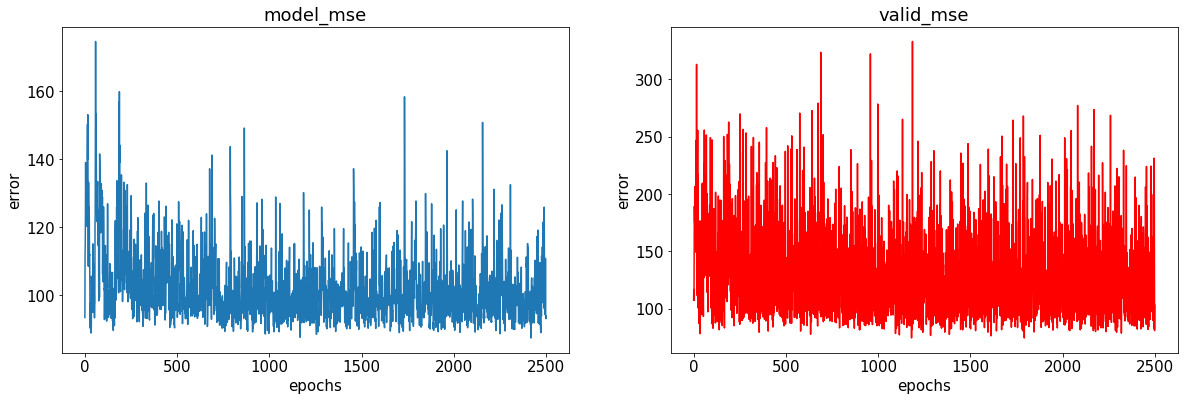

In [71]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(20, 6))

model_mse = fig.add_subplot(1, 2, 1)
plt.plot(results.history['mean_squared_error'])
model_mse.title.set_text("model_mse")
model_mse.set(xlabel="epochs")
model_mse.set(Ylabel="error")

valid_mse = fig.add_subplot(1, 2, 2)
plt.plot(results.history['val_mean_squared_error'], color="r")
valid_mse.title.set_text("valid_mse")
valid_mse.set(xlabel="epochs")
valid_mse.set(Ylabel="error")

plt.show()

I'll load the saved "best" model to see how good it is. I'm setting the "compile" hyperparameter to false becasue I don't need to do any training of the model, just testing of how well it works. This prevents an error.

In [72]:
model = keras.models.load_model("./Models/proj_7_best_model.h5", compile=False)

prediction = model.predict(test_features)
error = sklearn.metrics.mean_squared_error(prediction, test_labels)
print(error)

105.85869405318518
